# NLP Assignment 1 (40% of grade): Text classification for Fake News Detection

This coursework will involve you implementing functions for a text classifier, which you will train to detect **fake news** in a corpus of approx. 10,000 statements, which will be split into a 80%/20% training/test split. 

In this template you are given the basis for that implementation, though some of the functions are missing, which you have to fill in.

Follow the instructions file **NLP_Assignment_1_Instructions.pdf** for details of each question - the outline of what needs to be achieved for each question is as below.

You must submit all **ipython notebooks and extra resources you need to run the code if you've added them** in the code submission, and a **2 page report (pdf)** in the report submission on QMPlus where you report your methods and findings according to the instructions file for each question.

In [1]:
!pip install nltk

In [2]:
import csv    # csv reader
import nltk
nltk.download('punkt')                         
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn import metrics


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gadad\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    # mentioning encoding ="utf-8" to avoid python compatiblity error
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))

def split_and_preprocess_data(percentage):

    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(pre_process(text)),label))
    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(pre_process(text)),label))

# Question 1: Input and Basic preprocessing (10 marks)

In [4]:
def convert_label(label):
    """Converts the multiple classes into two,
    making it a binary distinction between fake news and real."""
    #return label
    # Converting the multiclass labels to binary label
    labels_map = {
        'true': 'REAL',
        'mostly-true': 'REAL',
        'half-true': 'REAL',
        'false': 'FAKE',
        'barely-true': 'FAKE',
        'pants-fire': 'FAKE'
    }
    return labels_map[label]


def parse_data_line(data_line):
    # Should return a tuple of the label as just FAKE or REAL and the statement
    # e.g. (label, statement)
    #Answer: Assigning statement equal to 3rd column and label equal to 2nd column from the data
    statement=data_line[2]
    label=data_line[1]
    #Converting the 6 types of labels into two ie. "Real" and "Fake"
    label=convert_label(label)
    return (label, statement)

In [5]:

# Input: a string of one statement
def pre_process(text):
    # Should return a list of tokens
    # DESCRIBE YOUR METHOD IN WORDS
    #Answer: we are using word_tokenize method from nltk.tokenize to return a list of tokens
    return word_tokenize(text)


# Question 2: Basic Feature Extraction (20 marks)

In [6]:
global_feature_dict = {} # A global dictionary of features

def to_feature_vector(tokens):
    # Should return a dictionary containing features as keys, and weights as values
    # feature_vector is a dictionary which has words as its keys. Values for these keys are weights. Weights are defined as number of occurrences of a word.
    # Here, FreqDist method from nltk is used to get feature_vector dictionary. 
    frequency_dict = dict(FreqDist(tokens))
    # Keeping weight to be simply 1 for each word
    feature_vector = {}
    for key in  list(frequency_dict.keys()):
        feature_vector[key] = 1
    # features is defined as the list. global_feature_dict contains keys as words and values as weights. We are making a list of only keys from global_feature_dict. 
    #In following code we are building  global_feature_dict incremently. Where, if word is already present in global_feature_dict then only weights are updated 
    # else keys and weights are updated.
    features= list(global_feature_dict.keys())
    for feature in list(feature_vector.keys()):
        if feature in features:
            global_feature_dict[feature] = global_feature_dict[feature] + feature_vector[feature]
        else:
            global_feature_dict[feature] = feature_vector[feature]
    return feature_vector

In [7]:
# TRAINING AND VALIDATING OUR CLASSIFIER

def train_classifier(data):
    print("Training Classifier...")
    pipeline =  Pipeline([('svc', LinearSVC())])
    return SklearnClassifier(pipeline).train(data)

# Question 3: Cross-validation (20 marks)

In [8]:
from nltk.metrics.scores import precision
#solution
from sklearn.metrics import classification_report


def cross_validate(dataset, folds):
    results = []
    fold_size = int(len(dataset)/folds) + 1
    
    
    for i in range(0,len(dataset),int(fold_size)):
        # insert code here that trains and tests on the 10 folds of data in the dataset
        #printing the fold start and end per fold
        print("Fold start on items %d - %d" % (i, i+fold_size))
        #defining the labeled_featuresets which contains features and labels as tuples
        labeled_featuresets = []
        # for loop to accomodate all samples in last fold
        
        for train_ix in [ x for x in list(range(len(dataset))) if x not in list(range(i, min(len(dataset),i+fold_size+1),1))]:
            labeled_featuresets.append(dataset[train_ix])
        #defining the featuresets_val which is validation feature sets
        featuresets_val = []
        #defining the labelsets_val which is validation label sets
        labelsets_val = []
        #for loop to obtain validation feature and labels 
        for val_ix in [x for x in list(range(i, min(len(dataset),i+fold_size+1),1))]:
            (features,labels) = dataset[val_ix]
            featuresets_val.append(features)
            labelsets_val.append(labels) 
        # Training classifier on labeled feature sets
        classifier = train_classifier(labeled_featuresets)
        # Predicting on validation features using classifier 
        predictionsets = predict_labels(featuresets_val, classifier)
        #computing precision ,recall, F score for this fold and appending to the results
        
        final_scores = precision_recall_fscore_support(labelsets_val, predictionsets, average='weighted') # evaluate
        results.append(final_scores)
        # computing accuracy for this fold
        accuracy= metrics.accuracy_score(labelsets_val, predictionsets)
        
    # taking mean of precision, recall, F score, and accuracy
    precisions = [x[0] for x in results]
    recalls = [x[1] for x in results]
    Fscores = [x[0] for x in results]
    accuracies = accuracy
    cv_results = [np.mean(precisions), np.mean(recalls), np.mean(Fscores), np.mean(accuracies)]
    return cv_results

In [9]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(preProcess(reviewSample)))

In [10]:
# MAIN

# loading reviews
# initialize global lists that will be appended to by the methods below
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset


# references to the data files
data_file_path = 'fake_news.tsv'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path) 
# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

split_and_preprocess_data(0.8)

# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature_dict), sep='\n')


Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 10241 rawData, 0 trainData, 0 testData
Preparing training and test data...
After split, 10241 rawData, 8192 trainData, 2049 testData
Training Samples: 
8192
Features: 
15094


In [11]:
cross_validate(train_data, 10)  # will work and output overall performance of p, r, f-score when cv implemented

Fold start on items 0 - 820
Training Classifier...
Fold start on items 820 - 1640
Training Classifier...
Fold start on items 1640 - 2460
Training Classifier...
Fold start on items 2460 - 3280
Training Classifier...
Fold start on items 3280 - 4100
Training Classifier...
Fold start on items 4100 - 4920
Training Classifier...
Fold start on items 4920 - 5740
Training Classifier...
Fold start on items 5740 - 6560
Training Classifier...
Fold start on items 6560 - 7380
Training Classifier...
Fold start on items 7380 - 8200
Training Classifier...


[0.5654557290919816,
 0.5650937820632054,
 0.5654557290919816,
 0.6022167487684729]

# 4. Error Analysis (10 marks)

In [12]:
from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    cm = metrics.confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    plt.show()

In [13]:
# error analysis on first fold
classifier = train_classifier(train_data[820:])
featuresets_val = []
labelsets_val = []
for val_ix in [x for x in list(range(0,820,1))]:
    (features,labels) = train_data[val_ix]
    featuresets_val.append(features)
    labelsets_val.append(labels)
predictionsets = predict_labels(featuresets_val, classifier)

Training Classifier...


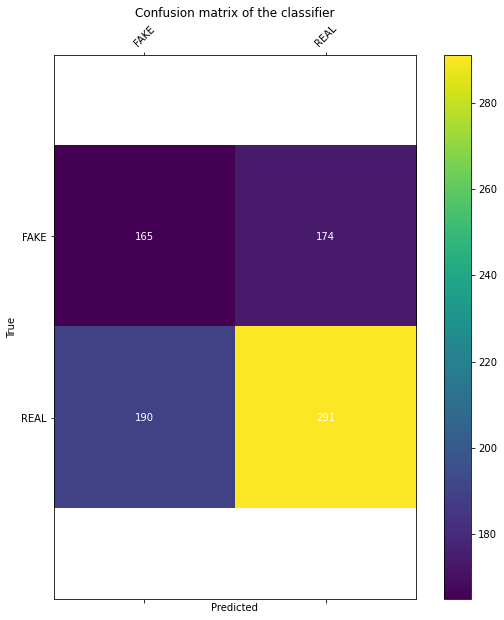

In [14]:
#plotting confusion matrix heat map
confusion_matrix_heatmap(labelsets_val, predictionsets, labels=['FAKE', 'REAL'])

In [15]:
# for loop for printing the false negatives and false positives for FAKE labels
for (sentence, true, predicted) in zip(raw_data[0:820], labelsets_val, predictionsets):
    if true == 'FAKE':
        if predicted == "REAL":
            print(f'Sentence:{sentence[0]} Ground Truth :{true} Predicted:{predicted}')
    elif predicted == "FAKE":
        print(f'Sentence:{sentence[0]} Ground Truth :{true} Predicted:{predicted}')
    

Sentence:Jim Dunnam has not lived in the district he represents for years now. Ground Truth :FAKE Predicted:REAL
Sentence:Says GOP primary opponents Glenn Grothman and Joe Leibham cast a compromise vote that cost $788 million in higher electricity costs. Ground Truth :REAL Predicted:FAKE
Sentence:When Mitt Romney was governor of Massachusetts, we didnt just slow the rate of growth of our government, we actually cut it. Ground Truth :FAKE Predicted:REAL
Sentence:Most of the (Affordable Care Act) has already in some sense been waived or otherwise suspended. Ground Truth :FAKE Predicted:REAL
Sentence:Women and men both are making less when you adjust for inflation than when John Kitzhaber was first elected governor. Ground Truth :FAKE Predicted:REAL
Sentence:We just had the best year for the auto industry in America in history. Ground Truth :REAL Predicted:FAKE
Sentence:Says Scott Walker favors cutting up to 350,000 families and children off health care. Ground Truth :REAL Predicted:FAKE


# Questions 5 (20%) and 6 (20%) (recommend starting a new notebook)

In [16]:
# Finally, check the accuracy of your classifier by training on all the traning data
# and testing on the test set
# Will only work once all functions are complete
functions_complete = True  # set to True once you're happy with your methods for cross val
if functions_complete:
    print(test_data[0])   # have a look at the first test data instance
    classifier = train_classifier(train_data)  # train the classifier
    test_true = [t[1] for t in test_data]   # get the ground-truth labels from the data
    test_pred = predict_labels([x[0] for x in test_data], classifier)  # classify the test data to get predicted labels
    final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted') # evaluate
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % final_scores[:3])

({'The': 1, 'Bush': 1, 'tax': 1, 'cuts': 1, 'helped': 1, 'to': 1, 'create': 1, 'a': 1, 'substantial': 1, 'part': 1, 'of': 1, 'the': 1, 'deficit': 1, '.': 1}, 'REAL')
Training Classifier...
Done training!
Precision: 0.568167
Recall: 0.568570
F Score:0.568355
